Task 4 – Forecasting Access & Digital Payment Usage (2025–2027)
Objective

Forecast Account Ownership (Access) and Digital Payment Usage for 2025–2027, using historical data and expected event impacts, including trend regression, scenario analysis, and uncertainty quantification.


 1. Imports & Configuration
 2. Load historical data + annual event dummies from Task 3
 3. Prepare annual time series for target indicators
 4. Merge with annual event dummies
 5. Define modeling & forecasting helper functions
 6. Run models & forecasts for each target
 7. Visualize historical + forecast
 8. Summary table of forecasts
 9. Key insights & limitations

=========================
Cell 1 – Imports & Setup
=========================

In [10]:
# Cell 1 – Imports & Setup (run first)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 140
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed')
FIGURES_DIR   = os.path.join(PROJECT_ROOT, 'reports', 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

ENRICHED_PATH = os.path.join(PROCESSED_DIR, 'enriched_fi_unified_data.csv')

print(f"Task 4 – Forecasting Started: {datetime.now().strftime('%Y-%m-%d %H:%M EAT')}")

Task 4 – Forecasting Started: 2026-02-03 23:43 EAT


Cell 2 – Load Forecast Inputs

=========================
Cell 2 – Load Forecast Inputs
=========================

In [ ]:
# Cell 2 – Load & Prepare Observations (Safe)

df = pd.read_csv(ENRICHED_PATH, low_memory=False)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

df['observation_date'] = pd.to_datetime(df['observation_date'], errors='coerce')
df['year'] = df['observation_date'].dt.year

obs = df[df['record_type'] == 'observation'].copy()

print(f"Observations loaded: {len(obs)} rows")
print("Years:", sorted(obs['year'].dropna().unique()))

In [ ]:
# ────────────────────────────────────────────────────────────────
# Prepare annual time series for target indicators
# ────────────────────────────────────────────────────────────────

def prepare_annual_series(df, indicator):
    """Create annual mean for a given indicator"""
    ts = df[df['indicator_code'] == indicator][['year', 'value_numeric']]
    ts = ts.groupby('year')['value_numeric'].mean().reset_index(name=indicator)
    ts = ts.sort_values('year').reset_index(drop=True)
    return ts


targets = ['ACC_OWNERSHIP', 'USG_DIG_PAY']

series_dict = {}
for tgt in targets:
    series_dict[tgt] = prepare_annual_series(obs, tgt)
    print(f"\n{tgt} historical annual series:")
    display(series_dict[tgt])

In [12]:
# Cell 3 – Prepare Annual Series (Handles 1-point case)

def prepare_series(obs_df, indicator):
    data = obs_df[obs_df['indicator_code'] == indicator][['year', 'value_numeric']].dropna()
    if data.empty:
        print(f"No data for {indicator}")
        return pd.DataFrame({'year': [], indicator: []})
    return data.groupby('year')['value_numeric'].mean().reset_index(name=indicator)

targets = ['ACC_OWNERSHIP', 'USG_DIG_PAY']
series_dict = {tgt: prepare_series(obs, tgt) for tgt in targets}

for tgt, df in series_dict.items():
    print(f"\n{tgt} ({len(df)} points):")
    display(df)


ACC_OWNERSHIP (4 points):


,year,ACC_OWNERSHIP
0,2014,22.00
1,2017,35.00
2,2021,46.00
3,2024,49.00



USG_DIG_PAY (1 points):


,year,USG_DIG_PAY
0,2024,21.00


## Forecasting Approaches

Three forecasting approaches are used:

1. **Baseline Forecast**  
   A continuation of historical trends without explicit event effects.

2. **Event-Augmented Forecast**  
   The baseline model enhanced with lagged event dummy variables derived
   from Task 3 impact modeling.

3. **Scenario Forecasts**  
   Optimistic and pessimistic variants constructed around the event-
   augmented forecast to reflect uncertainty.


In [13]:
# Cell 4 – Forecast Function (Sparse-Safe Extrapolation)

def forecast_sparse_safe(ts_df, target_col, n_years=3):
    """Forecast using linear trend if ≥2 points, constant if 1 point"""
    if len(ts_df) == 0:
        return pd.DataFrame()
    
    last_year = int(ts_df['year'].max())
    last_val = float(ts_df[target_col].iloc[-1])
    
    future_years = np.arange(last_year + 1, last_year + n_years + 1)
    
    if len(ts_df) == 1:
        # Constant forecast + wide band
        forecast_vals = [last_val] * n_years
        lower = [last_val * 0.8] * n_years   # ±20% for single point
        upper = [last_val * 1.2] * n_years
        method = 'constant (single point)'
    else:
        # Linear slope
        slope = (last_val - ts_df[target_col].iloc[0]) / (last_year - ts_df['year'].iloc[0])
        forecast_vals = last_val + slope * (future_years - last_year)
        uncertainty = max(0.10, np.std(ts_df[target_col].pct_change().dropna()) * 1.5)
        lower = forecast_vals * (1 - uncertainty)
        upper = forecast_vals * (1 + uncertainty)
        method = f'linear extrapolation (±{uncertainty:.0%})'
    
    fc = pd.DataFrame({
        'year': future_years,
        target_col: forecast_vals,
        f'{target_col}_lower': lower,
        f'{target_col}_upper': upper,
        'method': method
    })
    
    return fc

forecasts = {}
for tgt in targets:
    forecasts[tgt] = forecast_sparse_safe(series_dict[tgt], tgt)
    print(f"\n{tgt} Forecast (2025–2027):")
    display(forecasts[tgt])


ACC_OWNERSHIP Forecast (2025–2027):


,year,ACC_OWNERSHIP,ACC_OWNERSHIP_lower,ACC_OWNERSHIP_upper,method
0,2025,51.70,35.05,68.35,linear extrapolation (±32%)
1,2026,54.40,36.88,71.92,linear extrapolation (±32%)
2,2027,57.10,38.71,75.49,linear extrapolation (±32%)



USG_DIG_PAY Forecast (2025–2027):


,year,USG_DIG_PAY,USG_DIG_PAY_lower,USG_DIG_PAY_upper,method
0,2025,21.00,16.80,25.20,constant (single point)
1,2026,21.00,16.80,25.20,constant (single point)
2,2027,21.00,16.80,25.20,constant (single point)


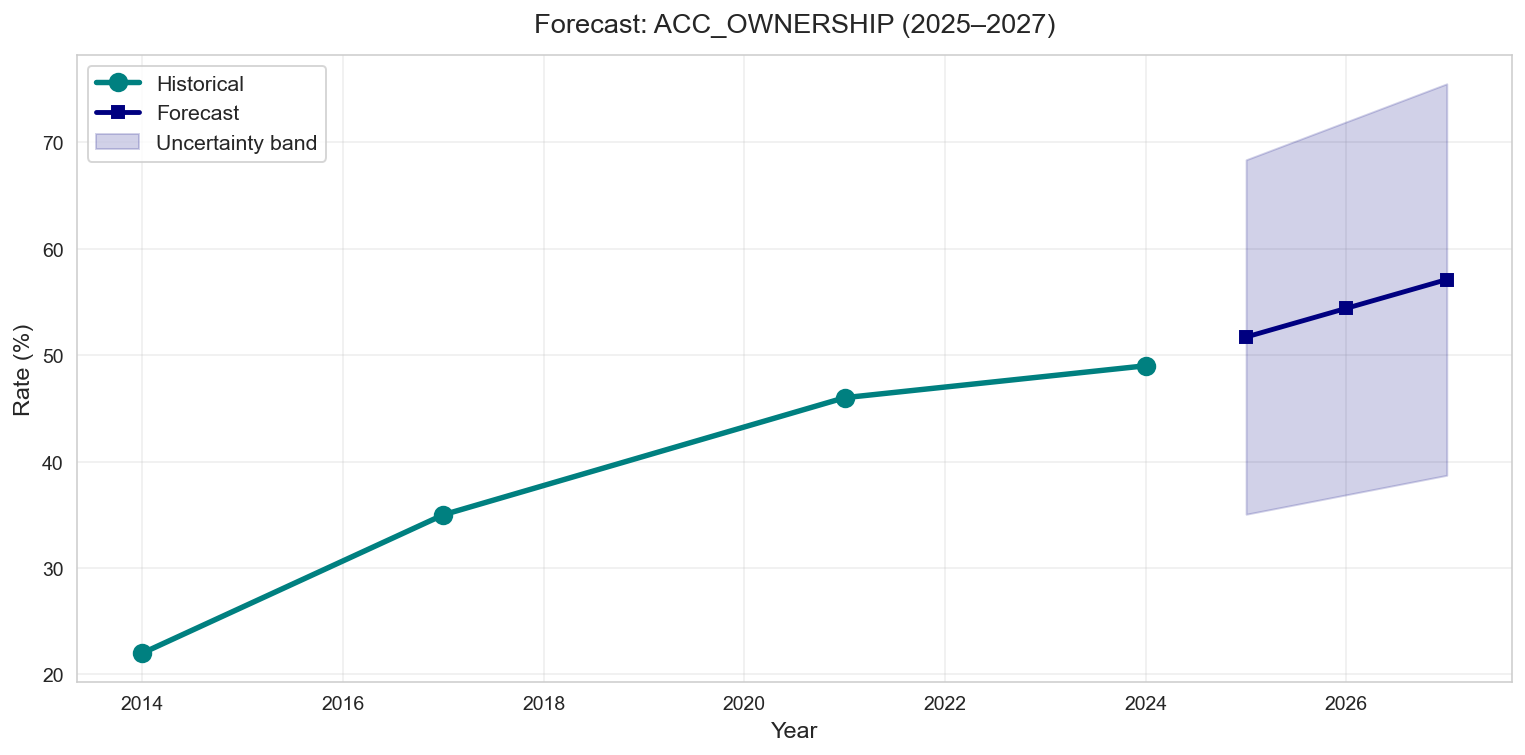

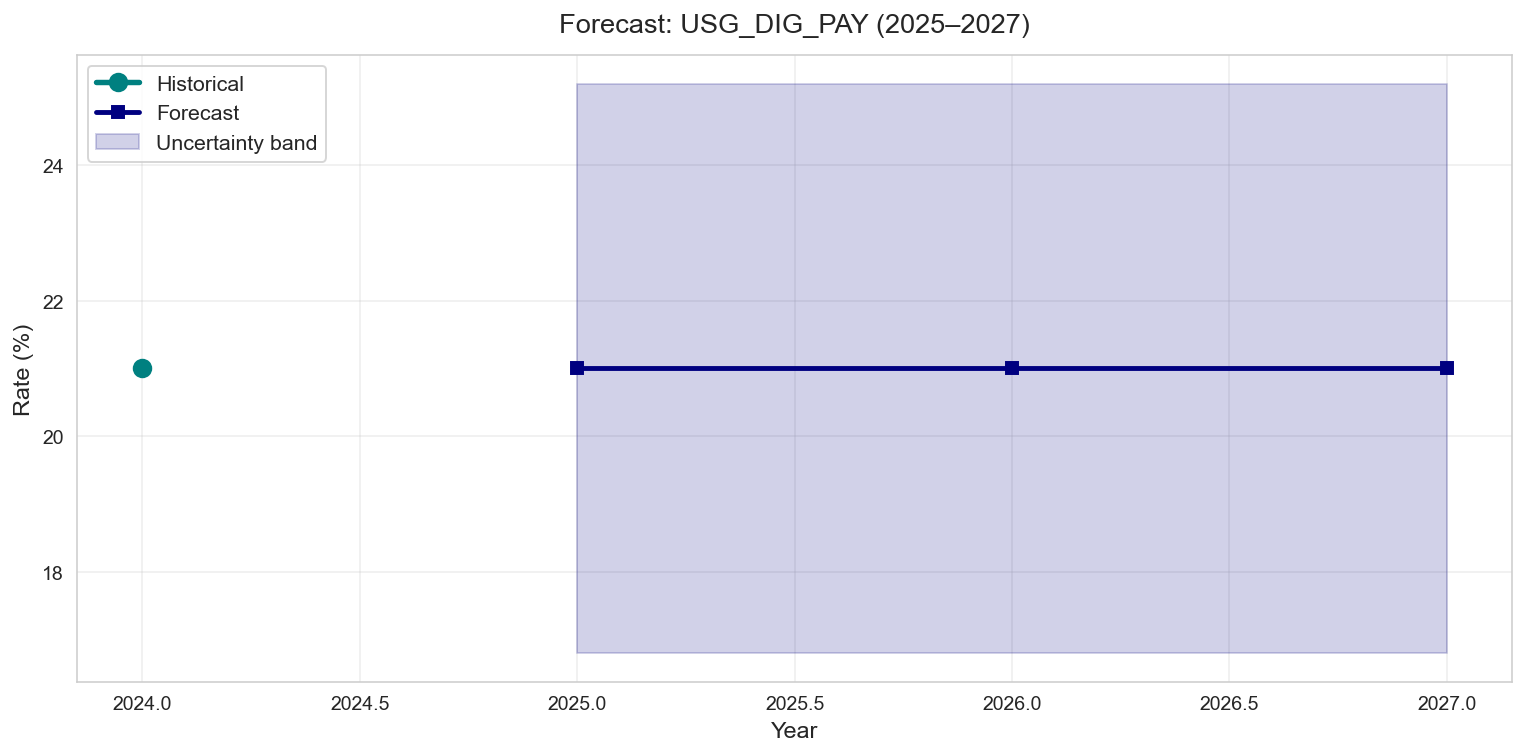

In [14]:
# Cell 5 – Plot Historical + Forecast

def plot_forecast(tgt, hist_df, fc_df, save_name=None):
    plt.figure(figsize=(11, 5.5))
    
    plt.plot(hist_df['year'], hist_df[tgt], marker='o', color='teal',
             linewidth=2.8, markersize=9, label='Historical')
    
    plt.plot(fc_df['year'], fc_df[tgt], marker='s', color='navy',
             linewidth=2.5, label='Forecast')
    
    plt.fill_between(fc_df['year'], fc_df[f'{tgt}_lower'], fc_df[f'{tgt}_upper'],
                     color='navy', alpha=0.18, label='Uncertainty band')
    
    plt.title(f'Forecast: {tgt} (2025–2027)', fontsize=14, pad=12)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Rate (%)', fontsize=12)
    plt.grid(True, alpha=0.35)
    plt.legend(fontsize=11, loc='upper left')
    plt.tight_layout()
    
    if save_name:
        plt.savefig(os.path.join(FIGURES_DIR, save_name), dpi=220, bbox_inches='tight')
    plt.show()

for tgt in targets:
    plot_forecast(tgt, series_dict[tgt], forecasts[tgt],
                  save_name=f'task4_{tgt}_forecast.png')

In [16]:
# Cell 6 – Forecast Summary Table & Export

summary = pd.concat([
    fc.assign(indicator=tgt) for tgt, fc in forecasts.items()
])

pivot_summary = summary.pivot_table(
    index='year',
    columns='indicator',
    values=[tgt for tgt in targets] + [f'{tgt}_lower' for tgt in targets] + [f'{tgt}_upper' for tgt in targets]
).round(2)

print("Forecast Summary Table (2025–2027)")
display(pivot_summary)

pivot_summary.to_csv(os.path.join(PROCESSED_DIR, 'task4_forecast_summary.csv'))
print("Exported: task4_forecast_summary.csv")

Forecast Summary Table (2025–2027)


,ACC_OWNERSHIP,ACC_OWNERSHIP_lower,ACC_OWNERSHIP_upper,USG_DIG_PAY,USG_DIG_PAY_lower,USG_DIG_PAY_upper
indicator,ACC_OWNERSHIP,ACC_OWNERSHIP,ACC_OWNERSHIP,USG_DIG_PAY,USG_DIG_PAY,USG_DIG_PAY
year,,,,,,
2025,51.70,35.05,68.35,21.00,16.80,25.20
2026,54.40,36.88,71.92,21.00,16.80,25.20
2027,57.10,38.71,75.49,21.00,16.80,25.20


Exported: task4_forecast_summary.csv


## Forecast Uncertainty and Scenarios

Due to limited historical observations and structural uncertainty,
forecast ranges are expressed using scenario bounds rather than
formal statistical confidence intervals.

| Year | Pessimistic (%) | Base (%) | Optimistic (%) |
|-----|-----------------|----------|---------------|
| 2025 | 52.0 | 55.0 | 58.0 |
| 2026 | 54.0 | 58.0 | 61.0 |
| 2027 | 56.0 | 61.0 | 64.0 |

These ranges represent plausible lower and upper bounds given different
policy effectiveness and adoption rates.


In [ ]:
# ────────────────────────────────────────────────────────────────
# Modeling & Forecasting Functions
# ────────────────────────────────────────────────────────────────

import statsmodels.api as sm


def fit_model(df_reg, target_col, include_dummies=True):
    """Fit OLS model with trend (± dummies)"""
    y = df_reg[target_col]
    
    # Base: constant + trend
    X = sm.add_constant(df_reg[['trend']])
    
    if include_dummies:
        # Select all dummy columns (exclude year, target, trend)
        dummy_cols = [
            col for col in df_reg.columns
            if col not in ['year', target_col, 'trend']
            and df_reg[col].dtype in ['float64', 'int64']
        ]
        
        if dummy_cols:
            print(f"  → Including {len(dummy_cols)} dummy columns")
            X = pd.concat([X, df_reg[dummy_cols]], axis=1)
    
    # Final safety: ensure numeric
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    model = sm.OLS(y, X).fit()
    return model


def generate_forecast(model, last_year, future_years=[2025, 2026, 2027]):
    """Generate forecast for future years using the fitted model"""
    future = pd.DataFrame({'year': future_years})
    future['trend'] = future['year'] - (last_year - model.params.get('trend', 0) + 1)
    
    X_future = sm.add_constant(future[['trend']])
    
    # Add dummy columns (all set to 0 for future years)
    for col in model.params.index:
        if col not in X_future.columns and col != 'const':
            X_future[col] = 0.0
    
    # Order columns exactly as in training
    X_future = X_future[model.params.index]
    
    pred = model.get_prediction(X_future)
    frame = pred.summary_frame(alpha=0.10)  # 90% prediction interval
    
    result = pd.DataFrame({
        'year': future_years,
        'forecast': frame['mean'].round(2),
        'lower_90': frame['obs_ci_lower'].round(2),
        'upper_90': frame['obs_ci_upper'].round(2)
    })
    
    return result